In [1]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
IMG_PATH = '/Volumes/My Passport for Mac/data/dogs-vs-cats/train/*'

In [4]:
files = glob.glob(IMG_PATH)

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(25000, 25000)

In [5]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)
print(cat_train[0])

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)
/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.493.jpg


In [6]:
train_dir = '/Volumes/My Passport for Mac/data/dogs-vs-cats/training_data'
val_dir = '/Volumes/My Passport for Mac/data/dogs-vs-cats/validation_data'
test_dir = '/Volumes/My Passport for Mac/data/dogs-vs-cats/test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob(train_dir + '/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob(val_dir + '/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (5630, 150, 150, 3) 	Validation dataset shape: (1945, 150, 150, 3)


In [8]:
print((train_files[0]).split('/')[-1])

cat.1000.jpg


(150, 150, 3)


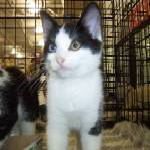

In [9]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [39]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0 0 0 0 0 0]


In [40]:
# A simple CNN model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

In [41]:
# Training Model
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 5630 samples, validate on 1945 samples
Epoch 1/30
5630/5630 [==============================] - 74s 13ms/step - loss: 0.6752 - accuracy: 0.5771 - val_loss: 0.6096 - val_accuracy: 0.6674
Epoch 2/30
5630/5630 [==============================] - 70s 12ms/step - loss: 0.5943 - accuracy: 0.6810 - val_loss: 0.7069 - val_accuracy: 0.5758
Epoch 3/30
5630/5630 [==============================] - 77s 14ms/step - loss: 0.5321 - accuracy: 0.7394 - val_loss: 0.5690 - val_accuracy: 0.7008
Epoch 4/30
5630/5630 [==============================] - 76s 14ms/step - loss: 0.4824 - accuracy: 0.7748 - val_loss: 0.4902 - val_accuracy: 0.7614
Epoch 5/30
5630/5630 [==============================] - 74s 13ms/step - loss: 0.4466 - accuracy: 0.8011 - val_loss: 0.4771 - val_accuracy: 0.7666
Epoch 6/30
5630/5630 [==============================] - 74s 13ms/step - loss: 0.4121 - accuracy: 0.8179 - val_loss: 0.4701 - val_accuracy: 0.7707
Epoch 7/30
5630/5630 [==============================] - 76s 14ms/step - loss

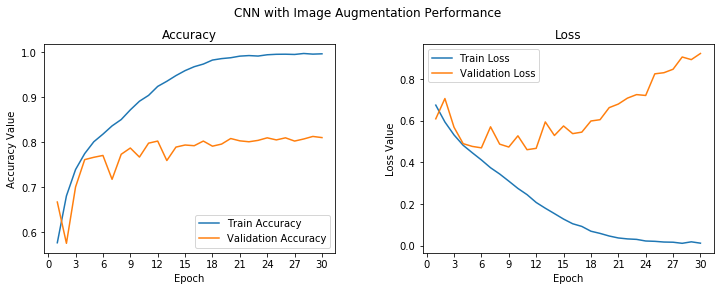

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, epochs/10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, epochs/10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [43]:
#CNN model with regulaization
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)         

Train on 5630 samples, validate on 1945 samples
Epoch 1/30
5630/5630 [==============================] - 50s 9ms/step - loss: 0.7099 - accuracy: 0.5124 - val_loss: 0.6789 - val_accuracy: 0.6129
Epoch 2/30
5630/5630 [==============================] - 50s 9ms/step - loss: 0.6652 - accuracy: 0.6037 - val_loss: 0.7024 - val_accuracy: 0.5537
Epoch 3/30
5630/5630 [==============================] - 51s 9ms/step - loss: 0.6073 - accuracy: 0.6691 - val_loss: 0.5546 - val_accuracy: 0.7003
Epoch 4/30
5630/5630 [==============================] - 51s 9ms/step - loss: 0.5595 - accuracy: 0.7208 - val_loss: 0.5538 - val_accuracy: 0.7316
Epoch 5/30
5630/5630 [==============================] - 51s 9ms/step - loss: 0.5071 - accuracy: 0.7533 - val_loss: 0.5237 - val_accuracy: 0.7383
Epoch 6/30
5630/5630 [==============================] - 51s 9ms/step - loss: 0.4650 - accuracy: 0.7865 - val_loss: 0.4627 - val_accuracy: 0.7841
Epoch 7/30
5630/5630 [==============================] - 51s 9ms/step - loss: 0.416

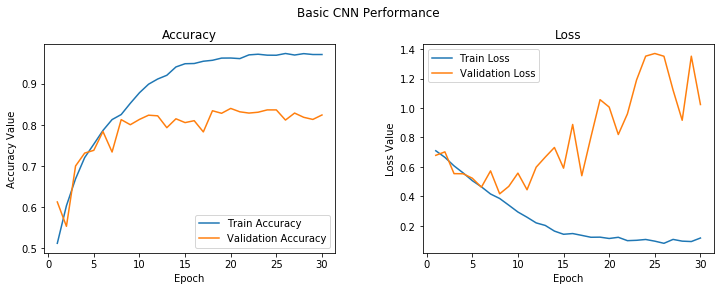

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [46]:
MODEL_PATH = '/Volumes/My Passport for Mac/model/cats_dogs_basic_cnn.h5'
model.save(MODEL_PATH)

In [47]:
#Image Augmentation

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


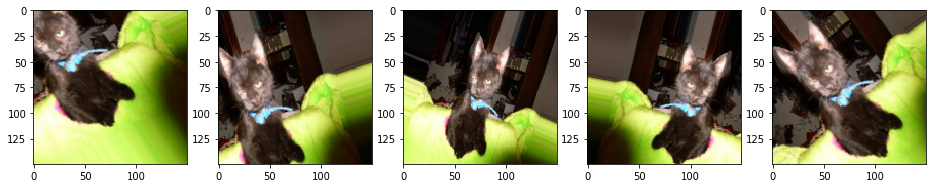

In [48]:

img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


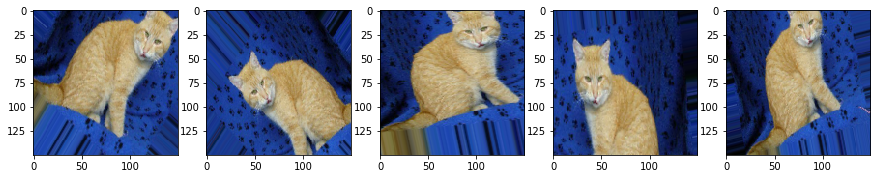

In [49]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [50]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)              

Epoch 1/100
100/100 [==============================] - 28s 282ms/step - loss: 0.6920 - accuracy: 0.5130 - val_loss: 0.7101 - val_accuracy: 0.5040
Epoch 2/100
100/100 [==============================] - 29s 288ms/step - loss: 0.6872 - accuracy: 0.5488 - val_loss: 0.6671 - val_accuracy: 0.6162
Epoch 3/100
100/100 [==============================] - 30s 300ms/step - loss: 0.6682 - accuracy: 0.5846 - val_loss: 0.6491 - val_accuracy: 0.5570
Epoch 4/100
100/100 [==============================] - 29s 290ms/step - loss: 0.6601 - accuracy: 0.6010 - val_loss: 0.6456 - val_accuracy: 0.6437
Epoch 5/100
100/100 [==============================] - 29s 290ms/step - loss: 0.6446 - accuracy: 0.6250 - val_loss: 0.5732 - val_accuracy: 0.6950
Epoch 6/100
100/100 [==============================] - 30s 301ms/step - loss: 0.6301 - accuracy: 0.6398 - val_loss: 0.8127 - val_accuracy: 0.6396
Epoch 7/100
100/100 [==============================] - 29s 292ms/step - loss: 0.6231 - accuracy: 0.6378 - val_loss: 0.5974 -

Epoch 57/100
100/100 [==============================] - 47s 473ms/step - loss: 0.4802 - accuracy: 0.7676 - val_loss: 0.3482 - val_accuracy: 0.7868
Epoch 58/100
100/100 [==============================] - 48s 481ms/step - loss: 0.4705 - accuracy: 0.7776 - val_loss: 0.8828 - val_accuracy: 0.7910
Epoch 59/100
100/100 [==============================] - 48s 482ms/step - loss: 0.4701 - accuracy: 0.7757 - val_loss: 0.5086 - val_accuracy: 0.7888
Epoch 60/100
100/100 [==============================] - 50s 504ms/step - loss: 0.4725 - accuracy: 0.7692 - val_loss: 0.1563 - val_accuracy: 0.8040
Epoch 61/100
100/100 [==============================] - 49s 487ms/step - loss: 0.4688 - accuracy: 0.7856 - val_loss: 0.4934 - val_accuracy: 0.7888
Epoch 62/100
100/100 [==============================] - 48s 475ms/step - loss: 0.4551 - accuracy: 0.7840 - val_loss: 0.5579 - val_accuracy: 0.7910
Epoch 63/100
100/100 [==============================] - 49s 486ms/step - loss: 0.4739 - accuracy: 0.7750 - val_loss: 0

In [51]:
model.save(‘cats_dogs_cnn_img_aug.h5’)

SyntaxError: invalid character in identifier (<ipython-input-51-861a9c6ca6bb>, line 1)